In [5]:
import numpy as np
import math
import os
import tensorflow as tf
import keras
import keras.backend as K

In [6]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout,Flatten,Concatenate, Masking
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [7]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth = True

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.9

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [8]:
def mse_multiDim_loss(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true - y_pred),axis = -1, keepdims=True))

In [27]:
distance_frmMonitor = 70 #in cm
ScreenWidth = 60.77 #cms excluding bezel width
dispHoriRes = 2560
display = np.array([2560,1440])

deg_per_px = math.degrees(math.atan2(.5*ScreenWidth, distance_frmMonitor)) / (.5*dispHoriRes)

def visualDeg_err(y_true, y_pred):
    y_true_temp = y_true * display
    y_pred_temp = y_pred * display
    return (K.mean(K.sqrt(K.sum(K.square(y_true_temp - y_pred_temp), axis=-1, keepdims=True))) * deg_per_px)

In [11]:
#input data
data_dir = "/home/niteesh/Documents/uni/HCI/Saarland/Npy_files/"
files = os.listdir(data_dir)
#for f in files:
#   file = data_dir + f
#    if f== files[0]:
#        data = np.load(file)
#    else:
#        data = np.vstack((data,np.load(file)))
        
data = np.load(data_dir + "9.npy")
print(data.shape)

(771, 11, 3)


In [28]:
#Hyper-parameters, constants
max_length_saccades = 10
learning_rate=0.0009
decay_rate = 1e-6

In [58]:
#Hyper-parameters, constants
max_length_saccades = 10
learning_rate=0.0009
decay_rate = 1e-6

In [59]:
#format data
Input = data[:,0:max_length_saccades,:]
#y = data[:,-1,:]
y = data[:,-1,0:2]
print(Input.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(Input, y, test_size=0.33)


(771, 10, 3)
(771, 2)


In [72]:
optimizer = keras.optimizers.Adam(lr=learning_rate,decay=decay_rate)
model = keras.models.Sequential()

#layer1 = model.add(Masking(mask_value=np.inf, input_shape=(max_length_saccades, 3),name = 'mask_layer'))

layer2 = model.add(LSTM(16, return_sequences=True, input_shape=(max_length_saccades, 3)))

#model.add(Dropout(0.2))

layer3 = model.add(LSTM(16,return_sequences=False,))  
# returns a sequence of vectors of dimension 32

#model.add(Dropout(0.2))



#layer4 = model.add(Dropout(0.2))
#model.add(Flatten())

#model.add(Dense(16, activation='relu'))

output_layer = model.add(Dense(2, activation='linear',name = 'output_layers'))
#output_layer = model.add(LSTM(2,activation=None,return_sequences=False)) 

# try using different optimizers and different optimizer configs
#model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])

model.compile(loss=mse_multiDim_loss,
              optimizer=optimizer,
              metrics=[visualDeg_err])
# Print summary
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(Input.shape))
print("Actual output: {}".format(y.shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 10, 16)            1280      
_________________________________________________________________
lstm_18 (LSTM)               (None, 16)                2112      
_________________________________________________________________
output_layers (Dense)        (None, 2)                 34        
Total params: 3,426
Trainable params: 3,426
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 10, 3)
Outputs: (None, 2)
Actual input: (771, 10, 3)
Actual output: (771, 2)


In [73]:
#Fit the model to data
history = model.fit(x = Input, y= y, batch_size= 32, epochs = 1000, verbose = 1, validation_split = 0.1, shuffle = True  )

Train on 693 samples, validate on 78 samples
Epoch 1/1000
693/693 [==============================] - 2s 3ms/step - loss: 0.2187 - visualDeg_err: 15.4090 - val_loss: 0.1402 - val_visualDeg_err: 11.8929
Epoch 2/1000
693/693 [==============================] - 1s 742us/step - loss: 0.1476 - visualDeg_err: 12.9328 - val_loss: 0.1274 - val_visualDeg_err: 11.6076
Epoch 3/1000
693/693 [==============================] - 1s 744us/step - loss: 0.1443 - visualDeg_err: 12.8908 - val_loss: 0.1260 - val_visualDeg_err: 11.4746
Epoch 4/1000
693/693 [==============================] - 1s 764us/step - loss: 0.1432 - visualDeg_err: 12.8494 - val_loss: 0.1270 - val_visualDeg_err: 11.5630
Epoch 5/1000
693/693 [==============================] - 0s 708us/step - loss: 0.1433 - visualDeg_err: 12.8256 - val_loss: 0.1259 - val_visualDeg_err: 11.4846
Epoch 6/1000
693/693 [==============================] - 0s 701us/step - loss: 0.1434 - visualDeg_err: 12.8827 - val_loss: 0.1271 - val_visualDeg_err: 11.5307
Epoch 7/1

693/693 [==============================] - 0s 671us/step - loss: 0.1147 - visualDeg_err: 11.3874 - val_loss: 0.1277 - val_visualDeg_err: 11.7662
Epoch 53/1000
693/693 [==============================] - 0s 657us/step - loss: 0.1165 - visualDeg_err: 11.1338 - val_loss: 0.1256 - val_visualDeg_err: 11.7479
Epoch 54/1000
693/693 [==============================] - 0s 658us/step - loss: 0.1109 - visualDeg_err: 11.0026 - val_loss: 0.1325 - val_visualDeg_err: 12.2310
Epoch 55/1000
693/693 [==============================] - 0s 670us/step - loss: 0.1119 - visualDeg_err: 11.0338 - val_loss: 0.1225 - val_visualDeg_err: 11.5980
Epoch 56/1000
693/693 [==============================] - 0s 650us/step - loss: 0.1100 - visualDeg_err: 11.0359 - val_loss: 0.1253 - val_visualDeg_err: 11.6489
Epoch 57/1000
693/693 [==============================] - 0s 647us/step - loss: 0.1084 - visualDeg_err: 10.8646 - val_loss: 0.1147 - val_visualDeg_err: 11.1565
Epoch 58/1000
693/693 [==============================] - 0s 

693/693 [==============================] - 0s 711us/step - loss: 0.0691 - visualDeg_err: 7.7445 - val_loss: 0.0852 - val_visualDeg_err: 8.5977
Epoch 105/1000
693/693 [==============================] - 0s 660us/step - loss: 0.0712 - visualDeg_err: 7.8897 - val_loss: 0.0838 - val_visualDeg_err: 8.4920
Epoch 106/1000
693/693 [==============================] - 0s 654us/step - loss: 0.0704 - visualDeg_err: 7.8054 - val_loss: 0.0835 - val_visualDeg_err: 8.3540
Epoch 107/1000
693/693 [==============================] - 0s 702us/step - loss: 0.0714 - visualDeg_err: 7.9571 - val_loss: 0.0833 - val_visualDeg_err: 8.3264
Epoch 108/1000
693/693 [==============================] - 0s 689us/step - loss: 0.0702 - visualDeg_err: 7.7277 - val_loss: 0.0829 - val_visualDeg_err: 8.3558
Epoch 109/1000
693/693 [==============================] - 1s 839us/step - loss: 0.0704 - visualDeg_err: 7.7827 - val_loss: 0.0808 - val_visualDeg_err: 8.2712
Epoch 110/1000
693/693 [==============================] - 0s 680us/

Epoch 156/1000
693/693 [==============================] - 0s 675us/step - loss: 0.0563 - visualDeg_err: 6.8103 - val_loss: 0.0626 - val_visualDeg_err: 7.0342
Epoch 157/1000
693/693 [==============================] - 0s 655us/step - loss: 0.0493 - visualDeg_err: 6.3032 - val_loss: 0.0750 - val_visualDeg_err: 7.7615
Epoch 158/1000
693/693 [==============================] - 0s 688us/step - loss: 0.0522 - visualDeg_err: 6.4978 - val_loss: 0.0575 - val_visualDeg_err: 7.0505
Epoch 159/1000
693/693 [==============================] - 0s 672us/step - loss: 0.0515 - visualDeg_err: 6.4722 - val_loss: 0.0600 - val_visualDeg_err: 6.8997
Epoch 160/1000
693/693 [==============================] - 0s 674us/step - loss: 0.0491 - visualDeg_err: 6.4052 - val_loss: 0.0635 - val_visualDeg_err: 7.4854
Epoch 161/1000
693/693 [==============================] - 0s 665us/step - loss: 0.0472 - visualDeg_err: 6.0817 - val_loss: 0.0678 - val_visualDeg_err: 7.5344
Epoch 162/1000
693/693 [============================

Epoch 208/1000
693/693 [==============================] - 0s 688us/step - loss: 0.0394 - visualDeg_err: 5.5463 - val_loss: 0.0568 - val_visualDeg_err: 7.1105
Epoch 209/1000
693/693 [==============================] - 0s 661us/step - loss: 0.0387 - visualDeg_err: 5.5366 - val_loss: 0.0439 - val_visualDeg_err: 5.5286
Epoch 210/1000
693/693 [==============================] - 0s 704us/step - loss: 0.0338 - visualDeg_err: 4.9295 - val_loss: 0.0456 - val_visualDeg_err: 5.7577
Epoch 211/1000
693/693 [==============================] - 0s 715us/step - loss: 0.0346 - visualDeg_err: 5.1467 - val_loss: 0.0460 - val_visualDeg_err: 5.5816
Epoch 212/1000
693/693 [==============================] - 0s 682us/step - loss: 0.0311 - visualDeg_err: 4.7387 - val_loss: 0.0455 - val_visualDeg_err: 5.6281
Epoch 213/1000
693/693 [==============================] - 0s 663us/step - loss: 0.0344 - visualDeg_err: 5.1522 - val_loss: 0.0522 - val_visualDeg_err: 6.2137
Epoch 214/1000
693/693 [============================

Epoch 260/1000
693/693 [==============================] - 0s 692us/step - loss: 0.0291 - visualDeg_err: 4.5262 - val_loss: 0.0441 - val_visualDeg_err: 5.5447
Epoch 261/1000
693/693 [==============================] - 0s 682us/step - loss: 0.0283 - visualDeg_err: 4.4296 - val_loss: 0.0438 - val_visualDeg_err: 5.4585
Epoch 262/1000
693/693 [==============================] - 0s 691us/step - loss: 0.0289 - visualDeg_err: 4.5328 - val_loss: 0.0436 - val_visualDeg_err: 5.4407
Epoch 263/1000
693/693 [==============================] - 0s 706us/step - loss: 0.0281 - visualDeg_err: 4.4231 - val_loss: 0.0432 - val_visualDeg_err: 5.4469
Epoch 264/1000
693/693 [==============================] - 0s 705us/step - loss: 0.0304 - visualDeg_err: 4.6787 - val_loss: 0.0442 - val_visualDeg_err: 5.9375
Epoch 265/1000
693/693 [==============================] - 0s 667us/step - loss: 0.0345 - visualDeg_err: 5.2332 - val_loss: 0.0473 - val_visualDeg_err: 5.9440
Epoch 266/1000
693/693 [============================

Epoch 312/1000
693/693 [==============================] - 0s 689us/step - loss: 0.0279 - visualDeg_err: 4.4308 - val_loss: 0.0439 - val_visualDeg_err: 5.5106
Epoch 313/1000
693/693 [==============================] - 0s 719us/step - loss: 0.0279 - visualDeg_err: 4.4458 - val_loss: 0.0536 - val_visualDeg_err: 6.1052
Epoch 314/1000
693/693 [==============================] - 0s 673us/step - loss: 0.0265 - visualDeg_err: 4.3438 - val_loss: 0.0427 - val_visualDeg_err: 5.4198
Epoch 315/1000
693/693 [==============================] - 0s 663us/step - loss: 0.0272 - visualDeg_err: 4.3760 - val_loss: 0.0472 - val_visualDeg_err: 5.8126
Epoch 316/1000
693/693 [==============================] - 0s 704us/step - loss: 0.0271 - visualDeg_err: 4.3957 - val_loss: 0.0415 - val_visualDeg_err: 5.3070
Epoch 317/1000
693/693 [==============================] - 0s 684us/step - loss: 0.0253 - visualDeg_err: 4.1692 - val_loss: 0.0429 - val_visualDeg_err: 5.4027
Epoch 318/1000
693/693 [============================

Epoch 364/1000
693/693 [==============================] - 0s 716us/step - loss: 0.0237 - visualDeg_err: 4.0893 - val_loss: 0.0429 - val_visualDeg_err: 5.4987
Epoch 365/1000
693/693 [==============================] - 0s 659us/step - loss: 0.0253 - visualDeg_err: 4.2737 - val_loss: 0.0423 - val_visualDeg_err: 5.4195
Epoch 366/1000
693/693 [==============================] - 0s 684us/step - loss: 0.0237 - visualDeg_err: 4.0867 - val_loss: 0.0419 - val_visualDeg_err: 5.4514
Epoch 367/1000
693/693 [==============================] - 0s 667us/step - loss: 0.0245 - visualDeg_err: 4.1881 - val_loss: 0.0408 - val_visualDeg_err: 5.2844
Epoch 368/1000
693/693 [==============================] - 0s 684us/step - loss: 0.0243 - visualDeg_err: 4.1828 - val_loss: 0.0423 - val_visualDeg_err: 5.2557
Epoch 369/1000
693/693 [==============================] - 0s 680us/step - loss: 0.0271 - visualDeg_err: 4.5408 - val_loss: 0.0449 - val_visualDeg_err: 5.9176
Epoch 370/1000
693/693 [============================

Epoch 416/1000
693/693 [==============================] - 0s 651us/step - loss: 0.0249 - visualDeg_err: 4.2993 - val_loss: 0.0427 - val_visualDeg_err: 5.4203
Epoch 417/1000
693/693 [==============================] - 0s 657us/step - loss: 0.0236 - visualDeg_err: 4.1742 - val_loss: 0.0550 - val_visualDeg_err: 6.4340
Epoch 418/1000
693/693 [==============================] - 0s 681us/step - loss: 0.0230 - visualDeg_err: 4.2029 - val_loss: 0.0394 - val_visualDeg_err: 5.1378
Epoch 419/1000
693/693 [==============================] - 0s 660us/step - loss: 0.0211 - visualDeg_err: 3.9397 - val_loss: 0.0422 - val_visualDeg_err: 5.2872
Epoch 420/1000
693/693 [==============================] - 0s 679us/step - loss: 0.0224 - visualDeg_err: 4.0897 - val_loss: 0.0399 - val_visualDeg_err: 5.1914
Epoch 421/1000
693/693 [==============================] - 0s 663us/step - loss: 0.0222 - visualDeg_err: 3.9912 - val_loss: 0.0441 - val_visualDeg_err: 5.4990
Epoch 422/1000
693/693 [============================

Epoch 468/1000
693/693 [==============================] - 1s 809us/step - loss: 0.0215 - visualDeg_err: 4.0184 - val_loss: 0.0397 - val_visualDeg_err: 5.0931
Epoch 469/1000
693/693 [==============================] - 1s 725us/step - loss: 0.0220 - visualDeg_err: 4.0184 - val_loss: 0.0383 - val_visualDeg_err: 5.4570
Epoch 470/1000
693/693 [==============================] - 0s 679us/step - loss: 0.0236 - visualDeg_err: 4.1195 - val_loss: 0.0435 - val_visualDeg_err: 5.4966
Epoch 471/1000
693/693 [==============================] - 0s 706us/step - loss: 0.0233 - visualDeg_err: 4.0510 - val_loss: 0.0413 - val_visualDeg_err: 5.3226
Epoch 472/1000
693/693 [==============================] - 0s 689us/step - loss: 0.0227 - visualDeg_err: 4.0345 - val_loss: 0.0387 - val_visualDeg_err: 5.1791
Epoch 473/1000
693/693 [==============================] - 0s 700us/step - loss: 0.0224 - visualDeg_err: 4.0575 - val_loss: 0.0369 - val_visualDeg_err: 4.9626
Epoch 474/1000
693/693 [============================

Epoch 520/1000
693/693 [==============================] - 0s 707us/step - loss: 0.0192 - visualDeg_err: 3.7253 - val_loss: 0.0417 - val_visualDeg_err: 5.3748
Epoch 521/1000
693/693 [==============================] - 0s 719us/step - loss: 0.0193 - visualDeg_err: 3.7348 - val_loss: 0.0388 - val_visualDeg_err: 5.1155
Epoch 522/1000
693/693 [==============================] - 0s 670us/step - loss: 0.0195 - visualDeg_err: 3.7481 - val_loss: 0.0360 - val_visualDeg_err: 4.9506
Epoch 523/1000
693/693 [==============================] - 0s 660us/step - loss: 0.0197 - visualDeg_err: 3.8154 - val_loss: 0.0360 - val_visualDeg_err: 4.9173
Epoch 524/1000
693/693 [==============================] - 0s 661us/step - loss: 0.0211 - visualDeg_err: 3.9635 - val_loss: 0.0419 - val_visualDeg_err: 5.9537
Epoch 525/1000
693/693 [==============================] - 0s 665us/step - loss: 0.0202 - visualDeg_err: 3.8700 - val_loss: 0.0397 - val_visualDeg_err: 5.2115
Epoch 526/1000
693/693 [============================

Epoch 572/1000
693/693 [==============================] - 0s 702us/step - loss: 0.0190 - visualDeg_err: 3.6954 - val_loss: 0.0386 - val_visualDeg_err: 5.4134
Epoch 573/1000
693/693 [==============================] - 0s 668us/step - loss: 0.0185 - visualDeg_err: 3.7379 - val_loss: 0.0380 - val_visualDeg_err: 5.2230
Epoch 574/1000
693/693 [==============================] - 0s 679us/step - loss: 0.0181 - visualDeg_err: 3.5978 - val_loss: 0.0366 - val_visualDeg_err: 5.2821
Epoch 575/1000
693/693 [==============================] - 0s 664us/step - loss: 0.0181 - visualDeg_err: 3.6173 - val_loss: 0.0368 - val_visualDeg_err: 5.3973
Epoch 576/1000
693/693 [==============================] - 0s 668us/step - loss: 0.0191 - visualDeg_err: 3.7547 - val_loss: 0.0389 - val_visualDeg_err: 5.1323
Epoch 577/1000
693/693 [==============================] - 0s 654us/step - loss: 0.0205 - visualDeg_err: 3.9165 - val_loss: 0.0397 - val_visualDeg_err: 5.2456
Epoch 578/1000
693/693 [============================

Epoch 624/1000
693/693 [==============================] - 0s 667us/step - loss: 0.0193 - visualDeg_err: 3.7658 - val_loss: 0.0429 - val_visualDeg_err: 5.4442
Epoch 625/1000
693/693 [==============================] - 0s 668us/step - loss: 0.0182 - visualDeg_err: 3.6836 - val_loss: 0.0382 - val_visualDeg_err: 5.0527
Epoch 626/1000
693/693 [==============================] - 0s 701us/step - loss: 0.0178 - visualDeg_err: 3.5423 - val_loss: 0.0401 - val_visualDeg_err: 5.1853
Epoch 627/1000
693/693 [==============================] - 0s 685us/step - loss: 0.0170 - visualDeg_err: 3.4533 - val_loss: 0.0382 - val_visualDeg_err: 5.0296
Epoch 628/1000
693/693 [==============================] - 0s 667us/step - loss: 0.0179 - visualDeg_err: 3.6221 - val_loss: 0.0356 - val_visualDeg_err: 4.9006
Epoch 629/1000
693/693 [==============================] - 0s 681us/step - loss: 0.0186 - visualDeg_err: 3.7695 - val_loss: 0.0403 - val_visualDeg_err: 5.3057
Epoch 630/1000
693/693 [============================

Epoch 676/1000
693/693 [==============================] - 0s 659us/step - loss: 0.0178 - visualDeg_err: 3.5695 - val_loss: 0.0351 - val_visualDeg_err: 4.9587
Epoch 677/1000
693/693 [==============================] - 1s 733us/step - loss: 0.0166 - visualDeg_err: 3.4321 - val_loss: 0.0352 - val_visualDeg_err: 5.1135
Epoch 678/1000
693/693 [==============================] - 0s 662us/step - loss: 0.0170 - visualDeg_err: 3.5688 - val_loss: 0.0384 - val_visualDeg_err: 5.1982
Epoch 679/1000
693/693 [==============================] - 0s 692us/step - loss: 0.0187 - visualDeg_err: 3.6696 - val_loss: 0.0354 - val_visualDeg_err: 4.9744
Epoch 680/1000
693/693 [==============================] - 0s 657us/step - loss: 0.0162 - visualDeg_err: 3.3812 - val_loss: 0.0360 - val_visualDeg_err: 4.9836
Epoch 681/1000
693/693 [==============================] - 0s 656us/step - loss: 0.0160 - visualDeg_err: 3.3620 - val_loss: 0.0376 - val_visualDeg_err: 5.0449
Epoch 682/1000
693/693 [============================

Epoch 728/1000
693/693 [==============================] - 0s 657us/step - loss: 0.0159 - visualDeg_err: 3.3618 - val_loss: 0.0384 - val_visualDeg_err: 5.3249
Epoch 729/1000
693/693 [==============================] - 0s 662us/step - loss: 0.0165 - visualDeg_err: 3.5309 - val_loss: 0.0367 - val_visualDeg_err: 5.4811
Epoch 730/1000
693/693 [==============================] - 0s 653us/step - loss: 0.0171 - visualDeg_err: 3.4987 - val_loss: 0.0392 - val_visualDeg_err: 5.2464
Epoch 731/1000
693/693 [==============================] - 0s 672us/step - loss: 0.0170 - visualDeg_err: 3.5548 - val_loss: 0.0381 - val_visualDeg_err: 5.1496
Epoch 732/1000
693/693 [==============================] - 1s 863us/step - loss: 0.0163 - visualDeg_err: 3.4479 - val_loss: 0.0358 - val_visualDeg_err: 5.1773
Epoch 733/1000
693/693 [==============================] - 1s 747us/step - loss: 0.0172 - visualDeg_err: 3.4743 - val_loss: 0.0393 - val_visualDeg_err: 5.3298
Epoch 734/1000
693/693 [============================

Epoch 780/1000
693/693 [==============================] - 0s 665us/step - loss: 0.0164 - visualDeg_err: 3.4612 - val_loss: 0.0366 - val_visualDeg_err: 4.9739
Epoch 781/1000
693/693 [==============================] - 0s 648us/step - loss: 0.0153 - visualDeg_err: 3.2574 - val_loss: 0.0336 - val_visualDeg_err: 4.8493
Epoch 782/1000
693/693 [==============================] - 0s 658us/step - loss: 0.0156 - visualDeg_err: 3.2916 - val_loss: 0.0336 - val_visualDeg_err: 4.9063
Epoch 783/1000
693/693 [==============================] - 0s 660us/step - loss: 0.0149 - visualDeg_err: 3.2462 - val_loss: 0.0366 - val_visualDeg_err: 4.9845
Epoch 784/1000
693/693 [==============================] - 0s 643us/step - loss: 0.0178 - visualDeg_err: 3.4842 - val_loss: 0.0370 - val_visualDeg_err: 5.1309
Epoch 785/1000
693/693 [==============================] - 0s 679us/step - loss: 0.0157 - visualDeg_err: 3.4348 - val_loss: 0.0342 - val_visualDeg_err: 5.0907
Epoch 786/1000
693/693 [============================

Epoch 832/1000
693/693 [==============================] - 0s 656us/step - loss: 0.0154 - visualDeg_err: 3.3316 - val_loss: 0.0375 - val_visualDeg_err: 5.1042
Epoch 833/1000
693/693 [==============================] - 0s 646us/step - loss: 0.0157 - visualDeg_err: 3.3334 - val_loss: 0.0373 - val_visualDeg_err: 5.0523
Epoch 834/1000
693/693 [==============================] - 0s 668us/step - loss: 0.0151 - visualDeg_err: 3.2381 - val_loss: 0.0362 - val_visualDeg_err: 5.0339
Epoch 835/1000
693/693 [==============================] - 0s 662us/step - loss: 0.0147 - visualDeg_err: 3.2544 - val_loss: 0.0375 - val_visualDeg_err: 5.1497
Epoch 836/1000
693/693 [==============================] - 0s 683us/step - loss: 0.0160 - visualDeg_err: 3.3570 - val_loss: 0.0348 - val_visualDeg_err: 5.1163
Epoch 837/1000
693/693 [==============================] - 0s 667us/step - loss: 0.0174 - visualDeg_err: 3.5074 - val_loss: 0.0354 - val_visualDeg_err: 4.9309
Epoch 838/1000
693/693 [============================

Epoch 884/1000
693/693 [==============================] - 0s 668us/step - loss: 0.0144 - visualDeg_err: 3.2131 - val_loss: 0.0361 - val_visualDeg_err: 4.9769
Epoch 885/1000
693/693 [==============================] - 0s 669us/step - loss: 0.0142 - visualDeg_err: 3.1418 - val_loss: 0.0364 - val_visualDeg_err: 5.1608
Epoch 886/1000
693/693 [==============================] - 0s 675us/step - loss: 0.0158 - visualDeg_err: 3.2790 - val_loss: 0.0358 - val_visualDeg_err: 5.1940
Epoch 887/1000
693/693 [==============================] - 0s 664us/step - loss: 0.0172 - visualDeg_err: 3.5790 - val_loss: 0.0407 - val_visualDeg_err: 5.6118
Epoch 888/1000
693/693 [==============================] - 0s 660us/step - loss: 0.0169 - visualDeg_err: 3.3817 - val_loss: 0.0416 - val_visualDeg_err: 5.4382
Epoch 889/1000
693/693 [==============================] - 0s 662us/step - loss: 0.0157 - visualDeg_err: 3.3649 - val_loss: 0.0375 - val_visualDeg_err: 5.1443
Epoch 890/1000
693/693 [============================

Epoch 936/1000
693/693 [==============================] - 0s 712us/step - loss: 0.0140 - visualDeg_err: 3.1768 - val_loss: 0.0359 - val_visualDeg_err: 4.9904
Epoch 937/1000
693/693 [==============================] - 0s 673us/step - loss: 0.0147 - visualDeg_err: 3.2012 - val_loss: 0.0379 - val_visualDeg_err: 5.0668
Epoch 938/1000
693/693 [==============================] - 0s 652us/step - loss: 0.0155 - visualDeg_err: 3.3119 - val_loss: 0.0351 - val_visualDeg_err: 4.9434
Epoch 939/1000
693/693 [==============================] - 0s 666us/step - loss: 0.0142 - visualDeg_err: 3.1479 - val_loss: 0.0335 - val_visualDeg_err: 4.8085
Epoch 940/1000
693/693 [==============================] - 0s 658us/step - loss: 0.0146 - visualDeg_err: 3.2059 - val_loss: 0.0353 - val_visualDeg_err: 4.9864
Epoch 941/1000
693/693 [==============================] - 0s 654us/step - loss: 0.0154 - visualDeg_err: 3.2939 - val_loss: 0.0351 - val_visualDeg_err: 5.3821
Epoch 942/1000
693/693 [============================

Epoch 988/1000
693/693 [==============================] - 0s 709us/step - loss: 0.0147 - visualDeg_err: 3.2497 - val_loss: 0.0315 - val_visualDeg_err: 4.6655
Epoch 989/1000
693/693 [==============================] - 0s 658us/step - loss: 0.0145 - visualDeg_err: 3.2448 - val_loss: 0.0379 - val_visualDeg_err: 5.0495
Epoch 990/1000
693/693 [==============================] - 0s 659us/step - loss: 0.0155 - visualDeg_err: 3.2220 - val_loss: 0.0328 - val_visualDeg_err: 4.6958
Epoch 991/1000
693/693 [==============================] - 0s 660us/step - loss: 0.0147 - visualDeg_err: 3.1883 - val_loss: 0.0373 - val_visualDeg_err: 5.0475
Epoch 992/1000
693/693 [==============================] - 0s 667us/step - loss: 0.0162 - visualDeg_err: 3.3472 - val_loss: 0.0354 - val_visualDeg_err: 4.9947
Epoch 993/1000
693/693 [==============================] - 0s 670us/step - loss: 0.0143 - visualDeg_err: 3.1974 - val_loss: 0.0357 - val_visualDeg_err: 4.9875
Epoch 994/1000
693/693 [============================

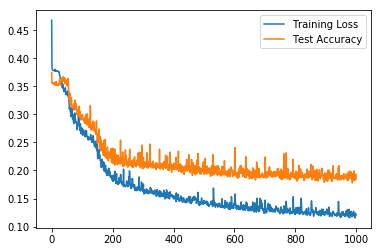

In [74]:
import matplotlib.pyplot as plt
#693/693 [==============================] - 0s 660us/step - loss: 0.0143 - val_loss: 0.0389
l_test = (history.history['val_loss'])
l_train = (history.history['loss'])
l_test = np.sqrt(history.history['val_loss'])
l_train = np.sqrt(history.history['loss'])
plt.plot(l_train, label="Training Loss")
plt.plot(l_test, label="Test Accuracy")
plt.legend()

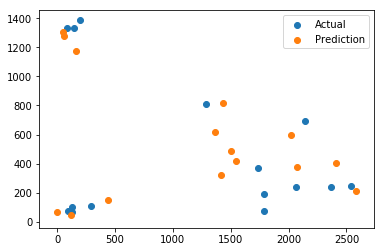

In [75]:
#model.outputs[0]
#m.outputs = 
display = [2560,1440]   
y_pred = model.predict(Input)

start = 5
end = 20
plt.scatter(y[start:end,0]*display[0],y[start:end,1]*display[1],label = "Actual")
plt.scatter(y_pred[start:end,0]*display[0],y_pred[start:end,1]*display[1], label = "Prediction")
plt.legend()

([array([  8.,  76.,  91.,  69., 133., 177.,  58.,  69.,  78.,  12.]),
  array([ 14.,  44.,  87.,  85., 120., 161., 151.,  76.,  28.,   5.])],
 array([-0.11194771,  0.01091693,  0.13378155,  0.2566462 ,  0.37951082,
         0.5023755 ,  0.6252401 ,  0.74810475,  0.87096936,  0.993834  ,
         1.1166986 ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

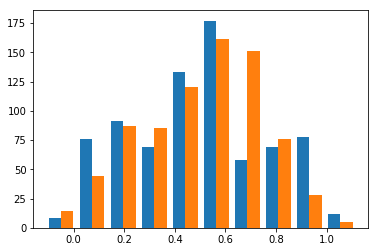

In [76]:
plt.hist(y_pred)

([array([ 75.,  84.,  38.,  82., 118., 117.,  68.,  35.,  86.,  68.]),
  array([ 43.,  75.,  91.,  51.,  73., 111., 119.,  92.,  71.,  45.])],
 array([0.00359975, 0.10314647, 0.2026932 , 0.30223992, 0.40178665,
        0.50133337, 0.6008801 , 0.70042682, 0.79997355, 0.89952027,
        0.999067  ]),
 <a list of 2 Lists of Patches objects>)

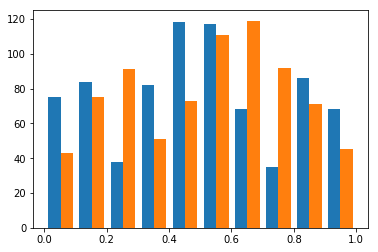

In [77]:
plt.hist(y)

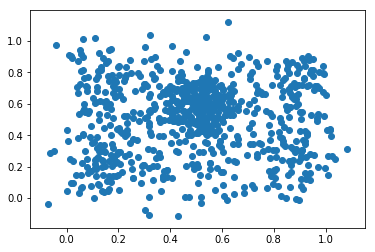

In [78]:
plt.scatter(y_pred[:,0],y_pred[:,1])

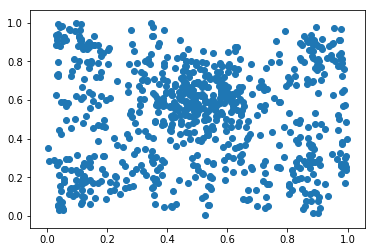

In [50]:
plt.scatter(y[:,0],y[:,1])